## The transient Universe


Let's go back to our previous example on the astrophysical transient.


8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data?

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from tqdm import tqdm
import corner
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import time
import warnings
warnings.filterwarnings("ignore")


plt.rcParams['figure.figsize']=(7,5) 
plt.rcParams['font.size']=16 
plt.rcParams['font.family']='Liberation Serif' 
plt.rcParams['figure.autolayout']=True 
plt.rcParams['mathtext.fontset'] = 'cm'

In [3]:
data = np.load('/home/irene/Downloads/transient.npy')

Text(0, 0.5, 'Flux')

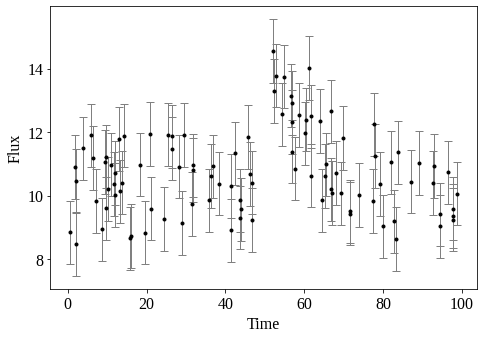

In [4]:
t = data[:, 0]
flux = data[:, 1]
err = data[:, 2]
t, y, yerr = data.T

plt.errorbar(t,flux,yerr=err,fmt='.k', ecolor='gray', lw=1,label='data', capsize = 4)
plt.xlabel("Time")
plt.ylabel("Flux")

In [5]:
ndim = 4

#exp_fit function
def exp_fit(x, par):
    return np.where(x < par[3], par[1], par[1] + par[0]*np.exp(-par[2]*(x - par[3])))

#gaus_fit function
def gaus_fit(x, par):
    return par[1] + par[0]*np.exp(-(x - par[3])**2/(2*par[2]**2))

#loglikelihood
def LogLike(par, data, model):
    y = model(data[:, 0], par)
    return -0.5*np.sum((data[:, 1]-y)**2/data[:, 2]**2 )

#logprior
t0min,t0max = 0,100
Amin,Amax = 0,50
bmin,bmax = 0,50
alphamin,alphamax = np.exp(-5),np.exp(5)
sigmamin, sigmamax = np.exp(-2),np.exp(2)

def prior_transform(u, model):
    par0 = np.array(u)  # copy u

    par0[0] = Amax*u[0] + Amin    
    par0[1] = bmax*u[1] + bmin
    if model == exp_fit:
        par0[2] = scipy.stats.loguniform.ppf(u[2], alphamin, alphamax)
    elif model == gaus_fit:
        par0[2] = scipy.stats.loguniform.ppf(u[2], sigmamin, sigmamax)
    par0[3] = t0max*u[3] + t0min

    return par0

## Fit with exponential function

In [6]:
sampler1 = dynesty.NestedSampler(LogLike, prior_transform, ndim, logl_args=[data, exp_fit], ptform_args = [exp_fit], nlive=100)
sampler1.run_nested()
sresults1 = sampler1.results

1677it [00:13, 127.44it/s, +100 | bound: 249 | nc: 1 | ncall: 47531 | eff(%):  3.746 | loglstar:   -inf < -48.759 <    inf | logz: -63.182 +/-  0.361 | dlogz:  0.001 >  0.109]


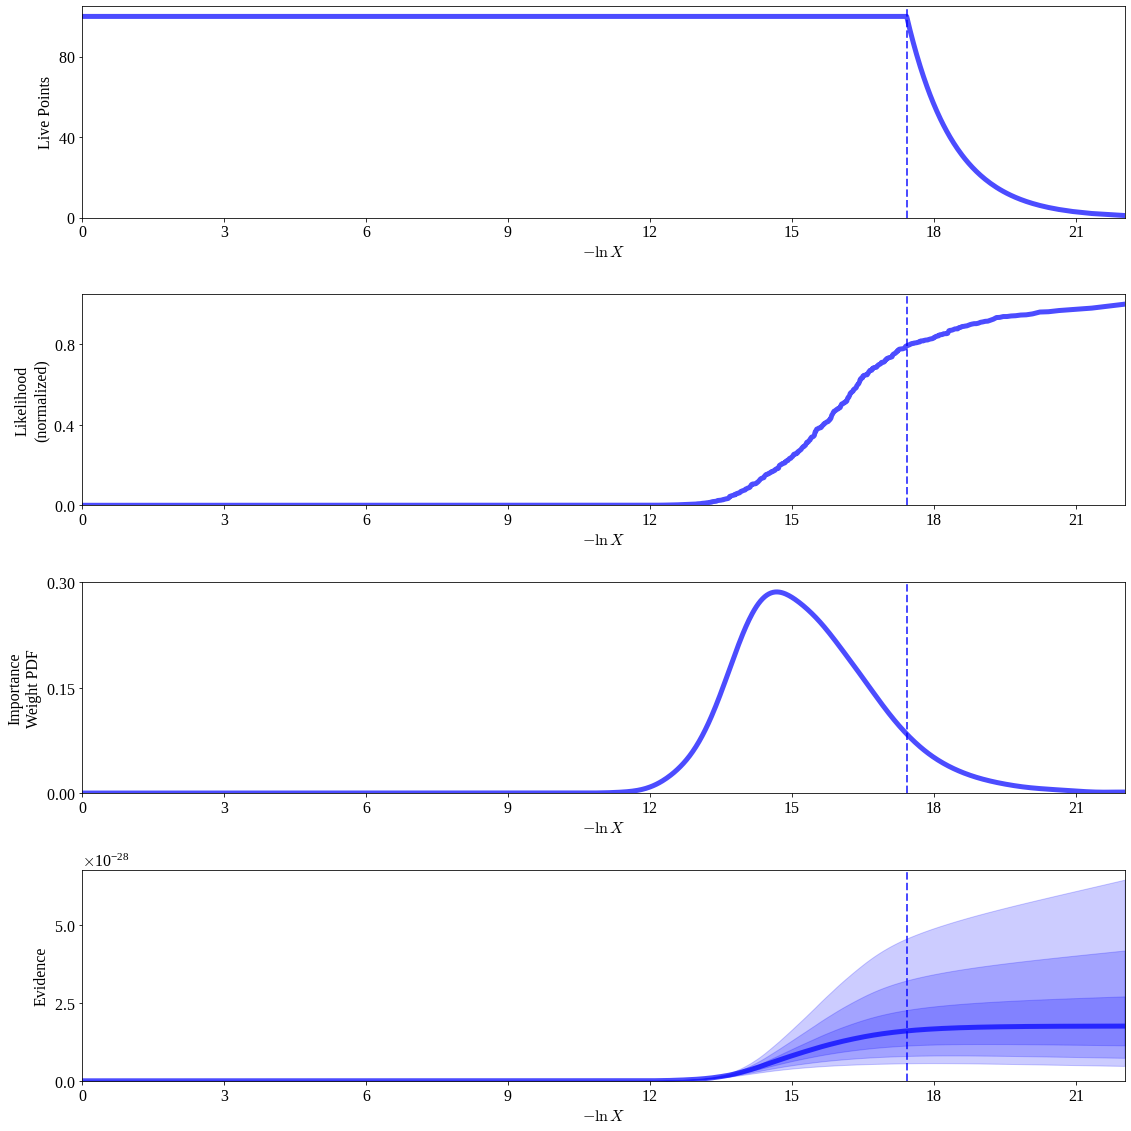

In [6]:
rfig, raxes = dyplot.runplot(sresults1)

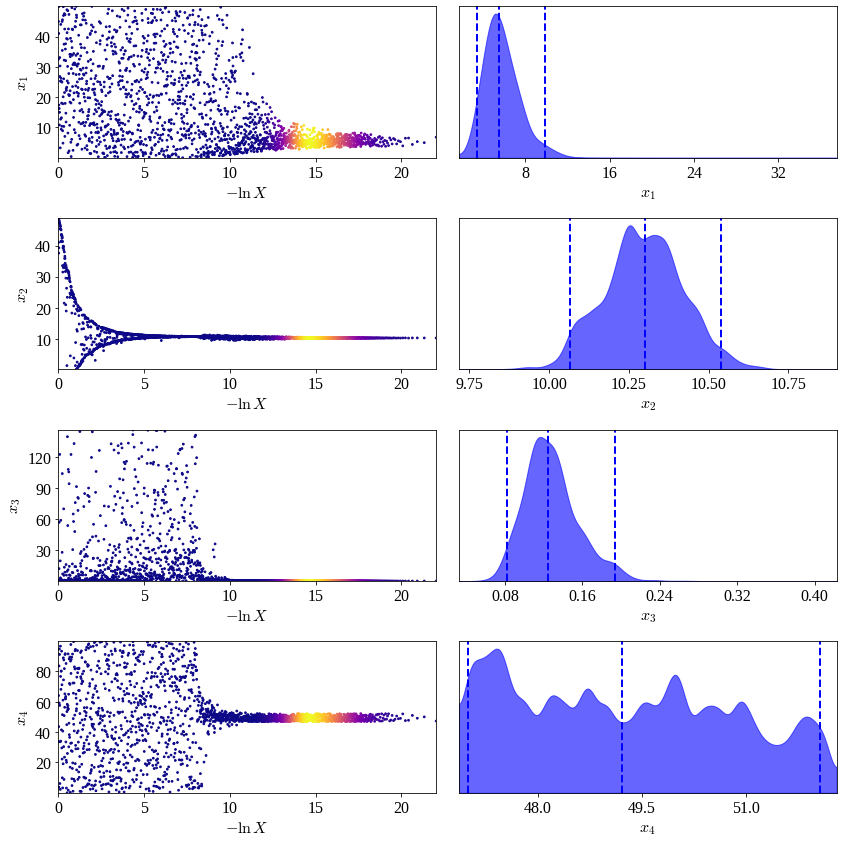

In [7]:
tfig, taxes = dyplot.traceplot(sresults1)

In [8]:
labels=['A', 'b', r'$\alpha$', r't$_{0}$']

# Extract sampling results.
samples = sresults1.samples  # samples
weights = np.exp(sresults1.logwt - sresults1.logz[-1])  # normalized weights
    
# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)

#print the parameters median and the errors
median_parameters = []
low_err = []
up_err = []

for i in range(ndim):
    low, med, up = np.percentile(samples_equal[:,i],[5,50, 95])
    median_parameters.append(med)
    low_err.append(med - low)
    up_err.append(up - med)
    print(labels[i], med, '+', up-med, '-', med-low)

A 5.37954618285894 + 3.6789284332945194 - 1.8139616507621446
b 10.299747444468958 + 0.19415397631787457 - 0.2163617333901584
$\alpha$ 0.12398170587048457 + 0.057070400682238454 - 0.036010752307783556
t$_{0}$ 49.211661975845814 + 2.6842916212239274 - 2.1391966137000082


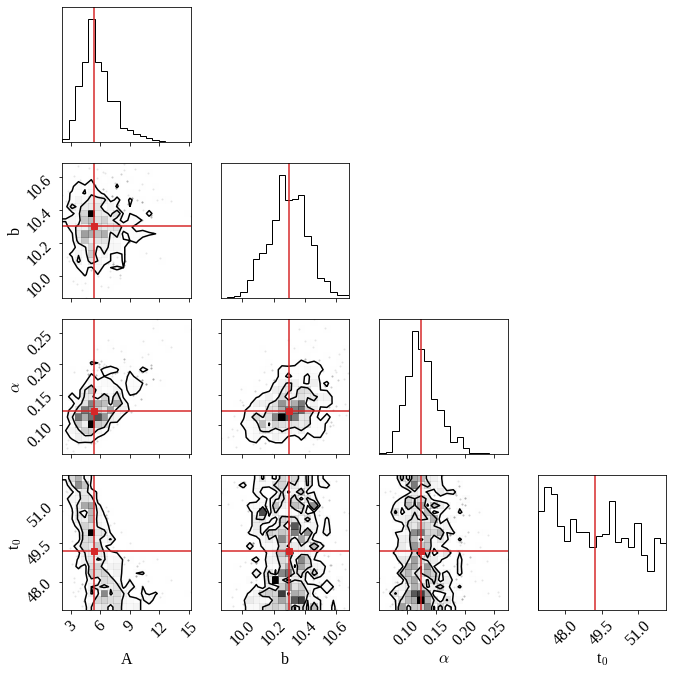

In [9]:
labels=['A', 'b', r'$\alpha$', r't$_{0}$']

# Make the corner plot
figure = corner.corner(samples_equal, labels=labels, levels=[0.68,0.95], truths=median_parameters, truth_color='tab:red');

## Fit with Gaussian model

In [10]:
sampler2 = dynesty.NestedSampler(LogLike, prior_transform, ndim, logl_args=[data, gaus_fit],  ptform_args = [gaus_fit], nlive=100)
sampler2.run_nested()
sresults2 = sampler2.results

1804it [00:08, 211.21it/s, +100 | bound: 180 | nc: 1 | ncall: 35414 | eff(%):  5.392 | loglstar:   -inf < -52.418 <    inf | logz: -68.116 +/-  0.373 | dlogz:  0.001 >  0.109]


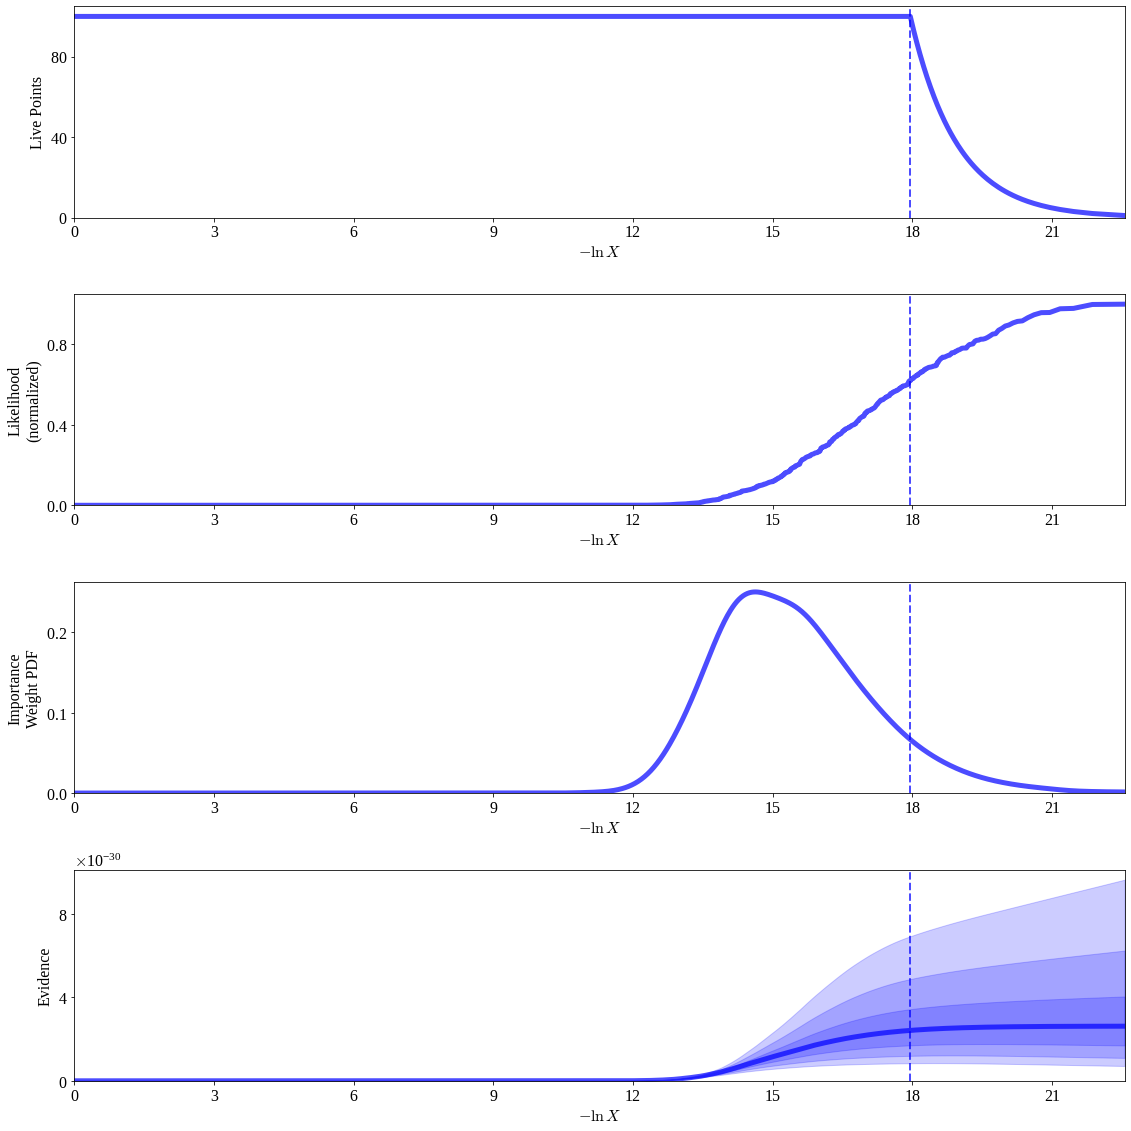

In [11]:
rfig, raxes = dyplot.runplot(sresults2)

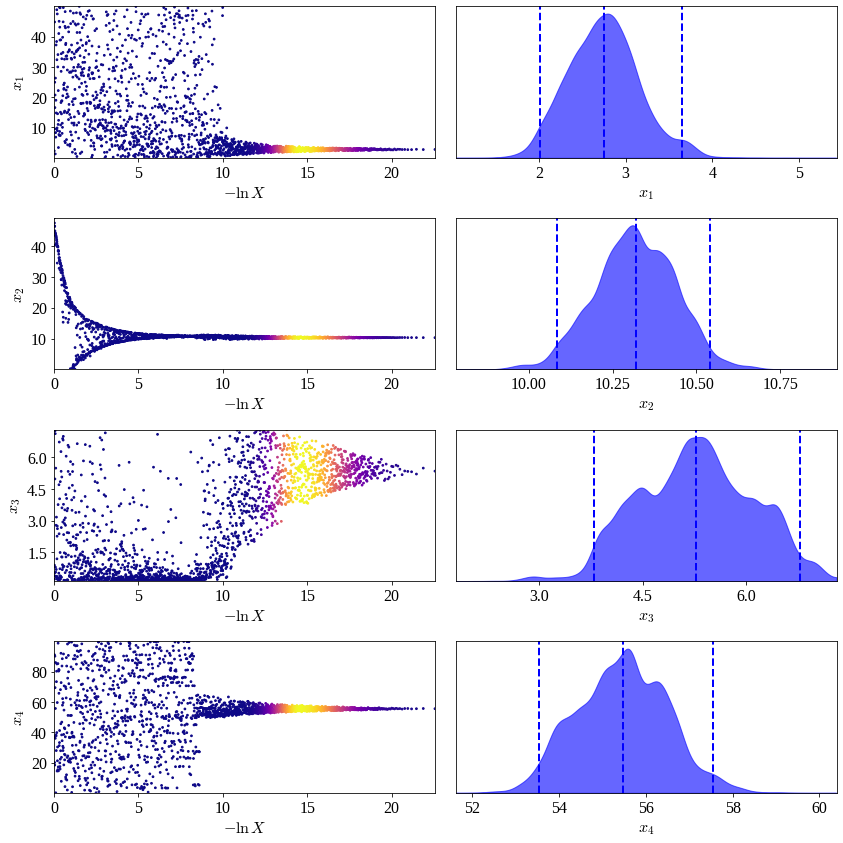

In [12]:
tfig, taxes = dyplot.traceplot(sresults2)

In [13]:
# Extract sampling results.
samples2 = sresults2.samples  # samples
weights2 = np.exp(sresults2.logwt - sresults2.logz[-1])  # normalized weights
    
# Resample weighted samples.
samples_equal2 = dyfunc.resample_equal(samples2, weights2)

#print the parameters median and the errors
median_parameters2 = []
low_err2 = []
up_err2 = []

for i in range(ndim):
    low2, med2, up2 = np.percentile(samples_equal2[:,i],[5,50, 95])
    median_parameters2.append(med2)
    low_err2.append(med2 - low2)
    up_err2.append(up2 - med2)
    print(labels[i], med2, '+', up2-med2, '-', med2-low2)

A 2.747308718054932 + 0.7092953772734503 - 0.6509199038645161
b 10.318136876072748 + 0.18821128597291548 - 0.20965815392542986
$\alpha$ 5.24086355056475 + 1.3491315147736085 - 1.3142967019396914
t$_{0}$ 55.482744698060195 + 1.6035090132965664 - 1.6703432802881935


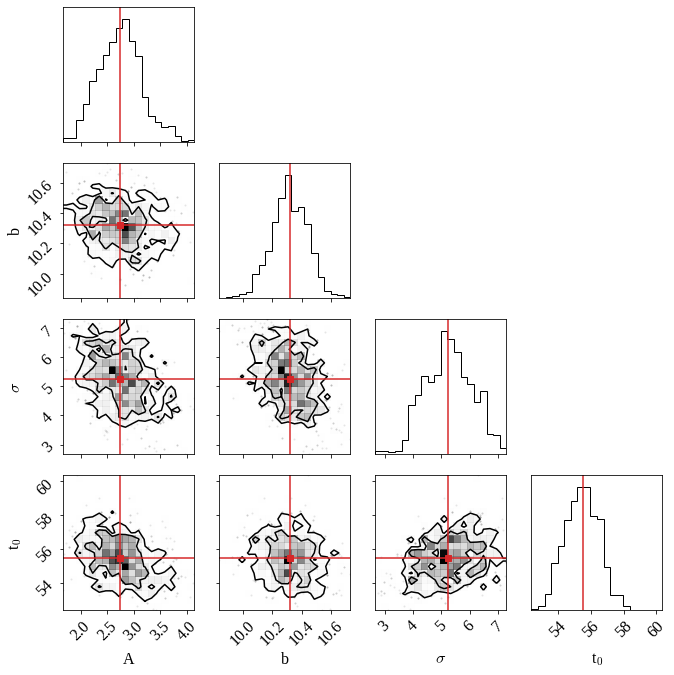

In [14]:
labels2=['A', 'b', r'$\sigma$', r't$_{0}$']

# Make the corner plot
figure = corner.corner(samples_equal2, labels=labels2, levels=[0.68,0.95], truths=median_parameters2, truth_color='tab:red');

(7.0, 17.0)

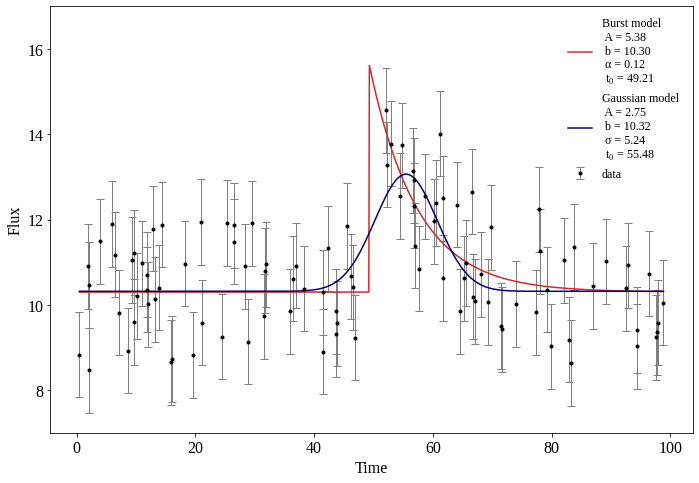

In [18]:
#draw the two fits obtained
plt.rcParams['figure.figsize']=(10,7) 

plt.errorbar(t,flux,yerr=err, fmt='.k', ecolor='gray', lw=1,label='data', capsize = 4)
plt.xlabel("Time")
plt.ylabel("Flux")

T = np.linspace(min(t), max(t), 1000)
plt.plot(T, exp_fit(T, median_parameters), color = 'tab:red', label = 'Burst model \n A = {:1.2f}\n b = {:1.2f} \n α = {:1.2f} \n t$_0$ = {:1.2f}'.format(median_parameters[0], median_parameters[1], median_parameters[2], median_parameters[3]))
plt.plot(T, gaus_fit(T, median_parameters2), color = 'navy', label = 'Gaussian model \n A = {:1.2f}\n b = {:1.2f} \n σ = {:1.2f} \n t$_0$ = {:1.2f}'.format(median_parameters2[0], median_parameters2[1], median_parameters2[2], median_parameters2[3]))

plt.legend(frameon=False, fontsize=12)
plt.ylim([7, 17])

In [20]:
evidence = sresults1.logz[-1] #evidence for burst model
print("Bayesian evidence", np.exp(evidence))

evidence2 = sresults2.logz[-1] #evidence for gaussian model
print("Bayesian evidence", np.exp(evidence2))

#Odds ratio
print('O(exp, gaus) =', np.exp(evidence-evidence2))

Bayesian evidence 1.7610095445093241e-28
Bayesian evidence 2.6145529759471753e-30
O(exp, gaus) = 67.35413513169922


The odds ratio is consistent with what I obtained with the product space method (that was 101)